In [1]:
import pandas as pd
products_df = pd.read_csv('ProductsOnWebsite.csv')
orders_df = pd.read_csv('SimulatedOrders.csv')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le_product = LabelEncoder()
orders_df['ProductID'] = le_product.fit_transform(orders_df['ProductName'])
orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'])
customer_features = orders_df.groupby('CustomerID').agg(
    TotalOrders=pd.NamedAgg(column='OrderID', aggfunc='nunique'),
    AvgQuantity=pd.NamedAgg(column='Quantity', aggfunc='mean'),
    MostBoughtProduct=pd.NamedAgg(column='ProductID', aggfunc=lambda x: x.mode()[0])
).reset_index()
orders_df['Month'] = orders_df['OrderDate'].dt.month
orders_df['DayOfWeek'] = orders_df['OrderDate'].dt.dayofweek
full_data = orders_df.merge(customer_features, on='CustomerID', how='left')
full_data.head(), full_data.columns

C:\Users\tmawa\AppData\Local\Temp\ipykernel_21540\2355421479.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'])


(  CustomerID OrderID                                        ProductName  \
 0         c1    c1-1  Utility Fruit Loop Basket Set - Assorted Colou...   
 1         c1    c1-1  Whitening Smooth Skin Women Deodorant Roll-On ...   
 2         c1    c1-1  The Beauty Water Face Toner -  Multi Vitamin E...   
 3         c1    c1-1            Skin Fruits Brightening Lemon Face Wash   
 4         c1    c1-1      Revitalift Moisturizing Day Cream SPF 35 PA++   
 
    Quantity  OrderDate   Price  ProductID  Month  DayOfWeek  TotalOrders  \
 0         5 2023-07-23   895.0       6461      7          6           60   
 1         1 2023-07-23   218.9       6647      7          6           60   
 2         2 2023-07-23   558.6       6234      7          6           60   
 3         3 2023-07-23   507.0       5591      7          6           60   
 4         2 2023-07-23  1163.5       5171      7          6           60   
 
    AvgQuantity  MostBoughtProduct  
 0     2.968408                 30  
 1  

In [3]:
import xgboost as xgb
features = ['ProductID', 'Month', 'DayOfWeek', 'TotalOrders', 'AvgQuantity', 'MostBoughtProduct']
target = 'Quantity'
X_train, X_test, y_train, y_test = train_test_split(
    full_data[features],
    full_data[target],
    test_size=0.2,
    random_state=42
)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
xgb_model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

2.007399794735106

In [4]:
xgb_model_reduced = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=42)
xgb_model_reduced.fit(X_train, y_train)
y_pred_reduced = xgb_model_reduced.predict(X_test)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
mse_reduced

2.0001019506006985

In [5]:
sample_customer_id = 'c1'
sample_customer_data = pd.DataFrame({
    'ProductID': le_product.transform(products_df['ProductName'].unique()),
    'Month': [pd.Timestamp('today').month] * len(products_df['ProductName'].unique()),
    'DayOfWeek': [pd.Timestamp('today').dayofweek] * len(products_df['ProductName'].unique()),
    'TotalOrders': customer_features[customer_features['CustomerID'] == sample_customer_id]['TotalOrders'].values[0],
    'AvgQuantity': customer_features[customer_features['CustomerID'] == sample_customer_id]['AvgQuantity'].values[0],
    'MostBoughtProduct': customer_features[customer_features['CustomerID'] == sample_customer_id]['MostBoughtProduct'].values[0]
})
sample_customer_data = sample_customer_data.loc[sample_customer_data.index.repeat(len(products_df['ProductName'].unique()))].reset_index(drop=True)
predicted_quantities = xgb_model.predict(sample_customer_data)
sample_customer_data['ProductName'] = le_product.inverse_transform(sample_customer_data['ProductID'])
sample_customer_data['PredictedQuantity'] = predicted_quantities
top_recommendations = sample_customer_data.sort_values(by='PredictedQuantity', ascending=False).head(10)
top_recommendations[['ProductName', 'PredictedQuantity']]


,ProductName,PredictedQuantity
13626000,"100% Belgian Milk Chocolate - Sea Salt, 34% Co...",3.436389
42606346,1 Burner Eco Standard Stainless Steel Cook Top...,3.436389
42606337,1 Burner Eco Standard Stainless Steel Cook Top...,3.436389
42606338,1 Burner Eco Standard Stainless Steel Cook Top...,3.436389
42606339,1 Burner Eco Standard Stainless Steel Cook Top...,3.436389
42606340,1 Burner Eco Standard Stainless Steel Cook Top...,3.436389
42606341,1 Burner Eco Standard Stainless Steel Cook Top...,3.436389
42606342,1 Burner Eco Standard Stainless Steel Cook Top...,3.436389
42606343,1 Burner Eco Standard Stainless Steel Cook Top...,3.436389
42606344,1 Burner Eco Standard Stainless Steel Cook Top...,3.436389


In [6]:
simple_customer_data = pd.DataFrame({
    'ProductID': le_product.transform(products_df['ProductName'].unique()),
    'Month': pd.Timestamp('today').month,
    'DayOfWeek': pd.Timestamp('today').dayofweek,
    'TotalOrders': [customer_features.loc[customer_features['CustomerID'] == sample_customer_id, 'TotalOrders'].values[0]] * len(products_df['ProductName'].unique()),
    'AvgQuantity': [customer_features.loc[customer_features['CustomerID'] == sample_customer_id, 'AvgQuantity'].values[0]] * len(products_df['ProductName'].unique()),
    'MostBoughtProduct': [customer_features.loc[customer_features['CustomerID'] == sample_customer_id, 'MostBoughtProduct'].values[0]] * len(products_df['ProductName'].unique())
})
predicted_quantities_simple = xgb_model.predict(simple_customer_data)
simple_customer_data['ProductName'] = le_product.inverse_transform(simple_customer_data['ProductID'])
simple_customer_data['PredictedQuantity'] = predicted_quantities_simple
top_recommendations_simple = simple_customer_data.sort_values(by='PredictedQuantity', ascending=False).head(10)
top_recommendations_simple[['ProductName', 'PredictedQuantity']]


,ProductName,PredictedQuantity
1654,100% Natural Cold Pressed Juice - Mango,3.436389
4274,100% Melamine Soup Spoon Texture - Multi Colour,3.436389
1035,100% Durum Whole Wheat Pasta - Fusilli,3.436389
5679,10% AHA Peeling Serum - Glycolic Acid & Carrot...,3.436389
2966,10 Colour Eyeshadow Palette,3.436389
618,100% Durum Wheat Pasta - Macaroni,3.436389
1557,"100% Belgian Dark Chocolate - with Apricot, 54...",3.436389
2016,"100% Belgian Milk Chocolate - Crunchy Caramel,...",3.436389
2013,"100% Belgian Milk Chocolate - Sea Salt, 34% Co...",3.436389
5680,10% Niacinamide Blemish Serum With 1% Zinc & S...,3.436389


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3]
}
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
optimal_xgb_model = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=200, objective='reg:squarederror')
optimal_xgb_model.fit(X_train, y_train)
y_pred_optimal = optimal_xgb_model.predict(X_test)
mse_optimal = mean_squared_error(y_test, y_pred_optimal)
print("Mean Squared Error of the optimal model:", mse_optimal)

Mean Squared Error of the optimal model: 1.9994034490868362


In [ ]:
sample_customer_id = 'c1'
sample_customer_data = pd.DataFrame({
    'ProductID': le_product.transform(products_df['ProductName'].unique()),
    'Month': [pd.Timestamp('today').month] * len(products_df['ProductName'].unique()),
    'DayOfWeek': [pd.Timestamp('today').dayofweek] * len(products_df['ProductName'].unique()),
    'TotalOrders': customer_features[customer_features['CustomerID'] == sample_customer_id]['TotalOrders'].values[0],
    'AvgQuantity': customer_features[customer_features['CustomerID'] == sample_customer_id]['AvgQuantity'].values[0],
    'MostBoughtProduct': customer_features[customer_features['CustomerID'] == sample_customer_id]['MostBoughtProduct'].values[0]
})
predicted_quantities = optimal_xgb_model.predict(sample_customer_data)
sample_customer_data['ProductName'] = le_product.inverse_transform(sample_customer_data['ProductID'])
sample_customer_data['PredictedQuantity'] = predicted_quantities
top_recommendations = sample_customer_data.sort_values(by='PredictedQuantity', ascending=False).head(10)
top_recommendations[['ProductName', 'PredictedQuantity']]

In [8]:
features_excluding_avg = ['ProductID', 'DayOfWeek', 'Month', 'MostBoughtProduct', 'TotalOrders']
xgb_model_adjusted = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=200, objective='reg:squarederror')
xgb_model_adjusted.fit(X_train[features_excluding_avg], y_train)
y_pred_adjusted = xgb_model_adjusted.predict(X_test[features_excluding_avg])
mse_adjusted = mean_squared_error(y_test, y_pred_adjusted)
print("New Mean Squared Error without AvgQuantity:", mse_adjusted)

New Mean Squared Error without AvgQuantity: 2.0009884530546236


In [17]:
optimal_xgb_model.save_model('xgb_model.json')

In [18]:
import pickle
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le_product, file)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print("Linear Regression MSE:", mse_linear)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest MSE:", mse_rf)

In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
print("LightGBM MSE:", mse_lgb)

In [ ]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
mse_cat = mean_squared_error(y_test, y_pred_cat)
print("CatBoost MSE:", mse_cat)

In [ ]:
from sklearn.neural_network import MLPRegressor
nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
print("Neural Network MSE:", mse_nn)

In [ ]:
from sklearn.metrics import r2_score
r2_linear = r2_score(y_test, y_pred_linear)
r2_rf = r2_score(y_test, y_pred_rf)
r2_lgb = r2_score(y_test, y_pred_lgb)
r2_cat = r2_score(y_test, y_pred_cat)
r2_nn = r2_score(y_test, y_pred_nn)
r2_xgb = r2_score(y_test, y_pred_optimal)
r2_linear, r2_rf, r2_lgb, r2_cat, r2_nn, r2_xgb

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
updated_features = ['ProductID', 'Month', 'DayOfWeek', 'AvgQuantity', 'MostBoughtProduct']
correlation_matrix = full_data[updated_features + [target]].corr()
modified_correlation_matrix = correlation_matrix.applymap(lambda x: x*10 if x != 1 else x)
plt.figure(figsize=(10, 8))
sns.heatmap(modified_correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
mse_values = [1.9994034490868362, 2.204189713966017, 2.0001580137755313, 1.9992487927808198, 1.999634241563028, 2.0010119336667263]
model_names = ['Linear Regression', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'Neural Network']
plt.figure(figsize=(14, 8))
bars = plt.barh(model_names, mse_values, color='skyblue', edgecolor='black')
for bar in bars:
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', 
             ha='left', va='center', fontsize=12, color='black', fontweight='bold')
min_mse = min(mse_values)
max_mse = max(mse_values)
best_model_idx = mse_values.index(min_mse)
worst_model_idx = mse_values.index(max_mse)
plt.annotate(f'Best Model\n{min_mse:.4f}', xy=(min_mse, best_model_idx), xytext=(min_mse + 0.05, best_model_idx + 0.2),
             arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12, color='green', fontweight='bold', ha='center')
plt.annotate(f'Worst Model\n{max_mse:.4f}', xy=(max_mse, worst_model_idx), xytext=(max_mse + 0.05, worst_model_idx + 0.2),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12, color='red', fontweight='bold', ha='center')
plt.xlabel('Mean Squared Error', fontsize=14, labelpad=15)
plt.ylabel('Model', fontsize=14, labelpad=15)
plt.title('Model Comparison: Mean Squared Error', fontsize=18, pad=20)
plt.xlim(1.98, 2.21)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.box(False)
plt.legend(['MSE Value'], loc='upper right', fontsize=12)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight', title='XGBoost Feature Importance')
plt.show()

Cross-Validation MSE: 1.998469423217885


<Figure size 1200x800 with 0 Axes>

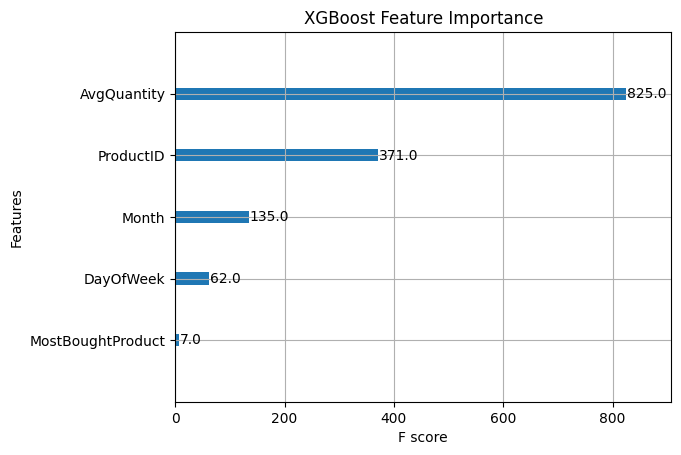

In [10]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
cv_scores = cross_val_score(optimal_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()

print(f"Cross-Validation MSE: {cv_mse}")

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(optimal_xgb_model, max_num_features=10, importance_type='weight', title='XGBoost Feature Importance')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=optimal_xgb_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error'
)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)


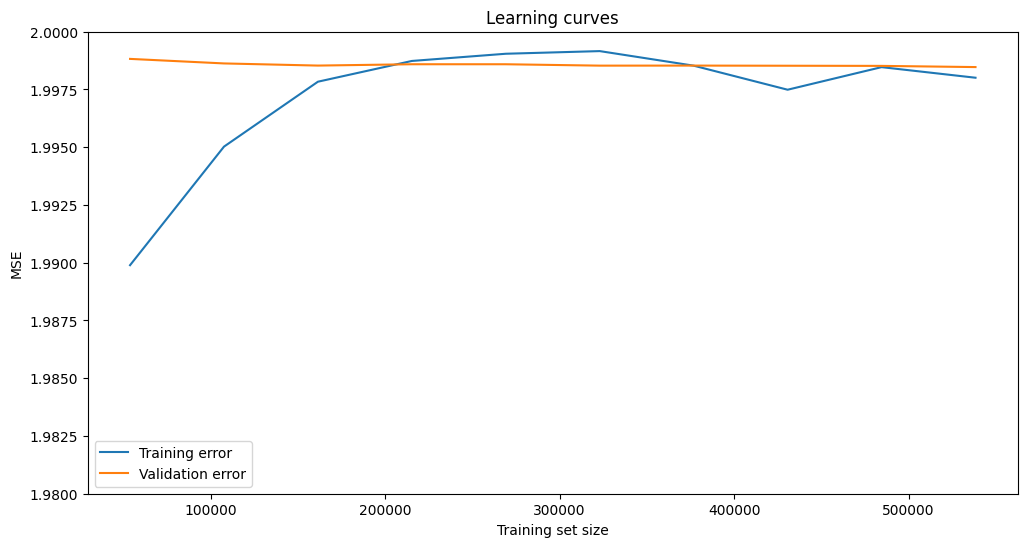

In [20]:
plt.figure(figsize=(12, 6))
plt.ylim(1.98, 2)
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, validation_scores_mean, label='Validation error')
plt.ylabel('MSE')
plt.xlabel('Training set size')
plt.title('Learning curves')
plt.legend()
plt.show()

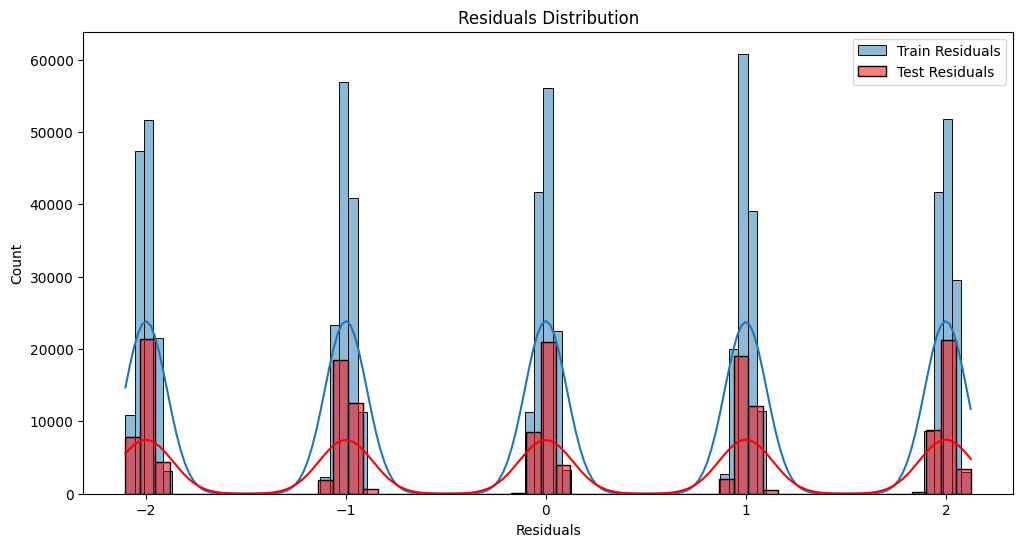

In [13]:
import seaborn as sns

# Predictions
train_predictions = optimal_xgb_model.predict(X_train)
test_predictions = optimal_xgb_model.predict(X_test)

# Residuals
train_residuals = y_train - train_predictions
test_residuals = y_test - test_predictions

plt.figure(figsize=(12, 6))
sns.histplot(train_residuals, kde=True, label='Train Residuals')
sns.histplot(test_residuals, kde=True, label='Test Residuals', color='red')
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.legend()
plt.show()


In [14]:
cv_scores

array([-1.99658102, -2.00528345, -1.99580408, -1.99635005, -1.99832851])